# Chapter 14 SQL

from Gayle Laakmann McDowell's "Cracking the Coding Interview", 6th ed.

Ron Wu

## 14.1 find tenants who rent multiple apartments

In [1]:
#! mysql.server status
! mysql.server start 
import MySQLdb  

Starting MySQL
. SUCCESS! 


In [2]:
conn = MySQLdb.connect(host="localhost", user="root")
cur = conn.cursor()
#cur.execute("Drop DATABASE NYC_Cheap_Apartment_LLC")
cur.execute("CREATE DATABASE NYC_Cheap_Apartment_LLC")
cur.close() 
#conn = MySQLdb.connect(host="localhost", user="root", db="NYC_Cheap_Apartment_LLC")

In [3]:
sqlQuery = '''  
            USE NYC_Cheap_Apartment_LLC;
            
            CREATE TABLE Complex (
                ComplexID INT NOT NULL, 
                ComplexName varchar(100),  
                    PRIMARY KEY(ComplexID)
            )   ENGINE=INNODB;
            
            CREATE TABLE Building (
                BuildingID INT NOT NULL, 
                BuildingName varchar(100), 
                ComplexID INT NOT NULL, 
                Address varchar(500),
                 PRIMARY KEY(BuildingID),
                 FOREIGN KEY (ComplexID)   REFERENCES Complex(ComplexID) 
            )   ENGINE=INNODB; 
            
            CREATE TABLE Apartment (
                AptID INT NOT NULL, 
                UnitNumber varchar(200), 
                BuildingID INT NOT NULL, 
                     PRIMARY KEY(AptID),
                     FOREIGN KEY (BuildingID)  REFERENCES Building(BuildingID) 
            )   ENGINE=INNODB; 
             
             
            CREATE TABLE Request (
                RequestID INT NOT NULL, 
                Status varchar(100), 
                AptID INT NOT NULL, 
                Description varchar(500),
                     PRIMARY KEY(RequestID),
                     FOREIGN KEY (AptID)  REFERENCES Apartment(AptID) 
            )   ENGINE=INNODB;
             
            CREATE TABLE Tenant (
                TenantID INT NOT NULL, 
                TenantName varchar(100),  
                     PRIMARY KEY(TenantID)
            )   ENGINE=INNODB; 
             
            CREATE TABLE AptTenant (  
                TenantID INT NOT NULL, 
                AptID INT NOT NULL, 
                     FOREIGN KEY (AptID)  REFERENCES Apartment(AptID),
                     FOREIGN KEY (TenantID)  REFERENCES Tenant(TenantID) 
            )   ENGINE=INNODB;
             
            '''

In [4]:
cur = conn.cursor()
cur.execute(sqlQuery)
cur.close() 

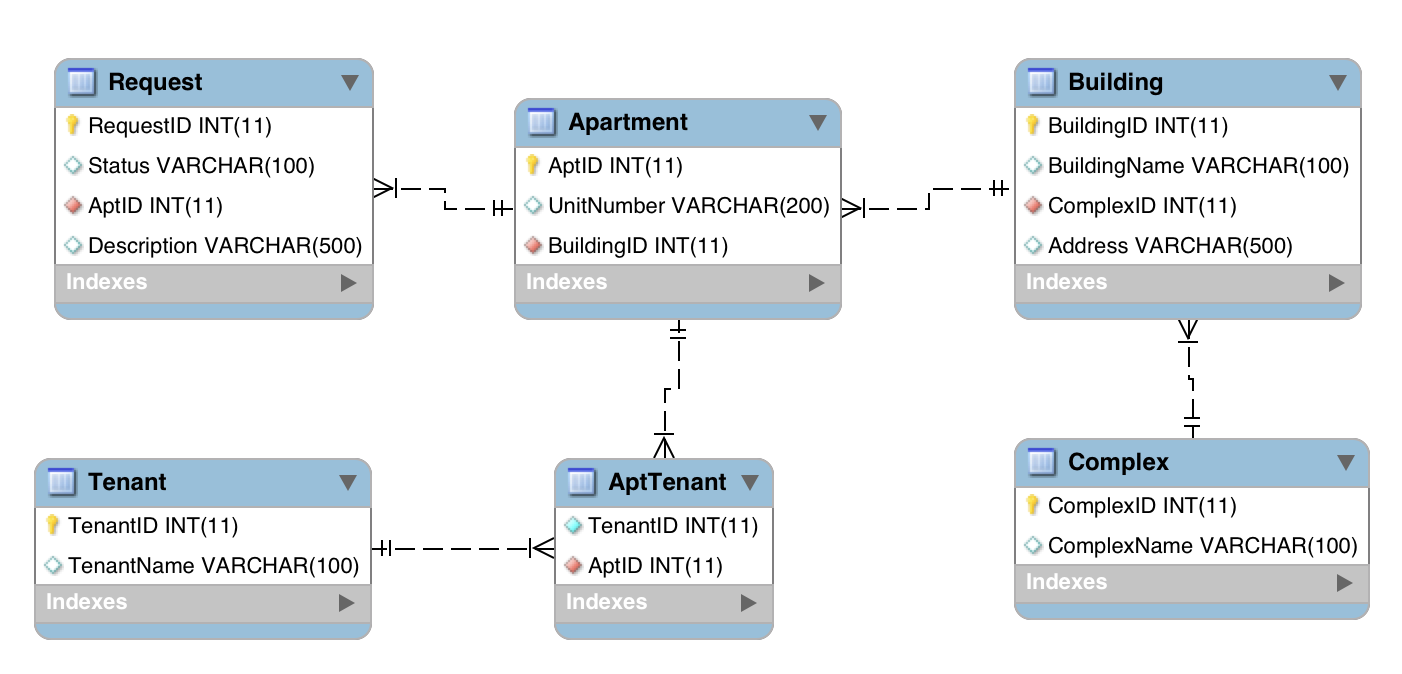

In [5]:
from IPython.display import Image
Image(filename='data/modelDiag.png') 

In [6]:
sqlQuery = ''' 
        
        USE NYC_Cheap_Apartment_LLC;
            
        INSERT INTO Complex (ComplexID, ComplexName)
        VALUES (100, 'Complex 100'),(101, 'Complex 101');
        
        INSERT INTO Building (BuildingID, BuildingName, ComplexID, Address)
        VALUES (99, 'Wooden Grade', 101, '99, Wooden Grade Rd.'), 
               (11, 'Lake Fire', 101, '99, Lake Fire Rd.');
        
        INSERT INTO Apartment (AptID, UnitNumber, BuildingID)
        VALUES (1, 'A01', 99), (2, 'A02', 11), (3, 'A03', 11);
        
        INSERT INTO Request (RequestID, Status, AptID, Description)
        VALUES (100001, 'open', 1, 'wood felling'), 
               (100002, 'open', 2, 'lake on fire');
               
        INSERT INTO Tenant (TenantID, TenantName)
        VALUES (1, 'James') , (2, 'Tommy');
        
        INSERT INTO AptTenant(TenantID, AptID)
        VALUES (1,2), (2,1), (2,3) ;
               
            ''' 

In [7]:
cur = conn.cursor()
cur.execute(sqlQuery)
cur.close() 
conn.commit()

In [8]:
def prettyPrint(results, cursor):
    '''copied from http://stackoverflow.com/questions/10865483/
                            print-results-in-mysql-format-with-python'''
    widths = []
    columns = []
    tavnit = '|'
    separator = '+' 

    for cd in cursor.description:
        widths.append(max(cd[2], len(cd[0])))
        columns.append(cd[0])

    for w in widths:
        tavnit += " %-"+"%ss |" % (w,)
        separator += '-'*w + '--+'

    print(separator)
    print(tavnit % tuple(columns))
    print(separator)
    for row in results:
        print(tavnit % row)
    print(separator)

In [9]:
cursor = conn.cursor()
cursor.execute("SELECT * FROM Tenant") 
result = cursor.fetchall() 
prettyPrint(result, cursor)

+----------+------------+
| TenantID | TenantName |
+----------+------------+
| 1        | James      |
| 2        | Tommy      |
+----------+------------+


In [10]:
# find tenants who rent more than 1 apartment
sqlQuery = '''
        select Tenant.TenantName, MultipleApartments
        from 
            (SELECT TenantID, count(*) as MultipleApartments
            FROM AptTenant
            group by TenantID
            having count(*) > 1) as aa
        left join Tenant
        on aa.TenantID = Tenant.TenantID;
'''

In [11]:
cursor = conn.cursor()
cursor.execute(sqlQuery) 
result = cursor.fetchall() 
prettyPrint(result, cursor)

+------------+--------------------+
| TenantName | MultipleApartments |
+------------+--------------------+
| Tommy      | 2                  |
+------------+--------------------+


## 14.2 list buildings with number of open requests 

In [12]:

sqlQuery = '''select buildingID, count(*) as openRequests
                from 
                    (SELECT AptID
                    FROM Request
                    where Status = 'open') as L
                left join Apartment
                on L.AptID = Apartment.AptID
                group by buildingID
'''

In [13]:
cursor = conn.cursor()
cursor.execute(sqlQuery) 
result = cursor.fetchall() 
prettyPrint(result, cursor)

+------------+--------------+
| buildingID | openRequests |
+------------+--------------+
| 11         | 1            |
| 99         | 1            |
+------------+--------------+


## 14.3 set open requests from building 11 to close

In [14]:

sqlQuery = '''
                update request
                set Status = 'close'
                where aptid in 
                    (SELECT AptID 
                     FROM Apartment
                     where buildingID = 11)
'''

In [15]:
cursor = conn.cursor()
cursor.execute(sqlQuery) 
cursor.close() 
conn.commit()

In [16]:

sqlQuery = '''select buildingID, count(*) as openRequests
                from 
                    (SELECT AptID
                    FROM Request
                    where Status = 'open') as L
                left join Apartment
                on L.AptID = Apartment.AptID
                group by buildingID
'''

In [17]:
cursor = conn.cursor()
cursor.execute("SELECT * FROM Request") 
result = cursor.fetchall() 
prettyPrint(result, cursor)
#now open requests from building 11 are close

+-----------+--------+-------+--------------+
| RequestID | Status | AptID | Description  |
+-----------+--------+-------+--------------+
| 100001    | open   | 1     | wood felling |
| 100002    | close  | 2     | lake on fire |
+-----------+--------+-------+--------------+


In [18]:
cursor.close()
conn.close()

## 14.4 what are the joins?

In [19]:
# INNER JOIN no NULL
# FULL JOIN KEEP NULL
# LEFT JOIN all raws from left in display, no match right raw show NULL

## 14.5 denormalization

In [20]:
# keep repeat information in exchange for less join to perform

## 14.6 design an entity people campanies databases

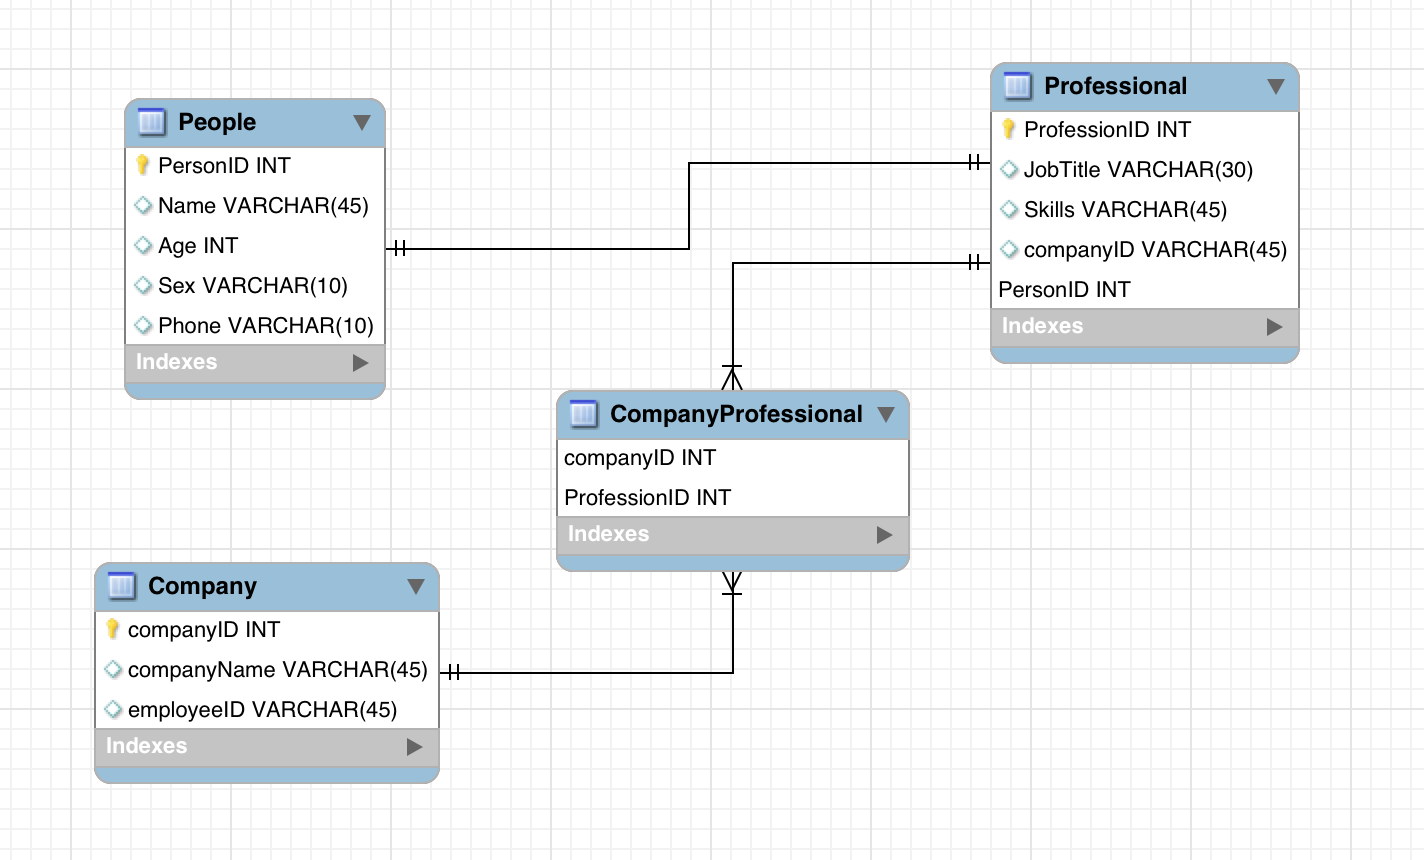

In [21]:
from IPython.display import Image
Image(filename='data/modelDiag_profession.png') 

#professional is a person
#professional works for many companies
#company has many professionals

## 14.7 design grade database

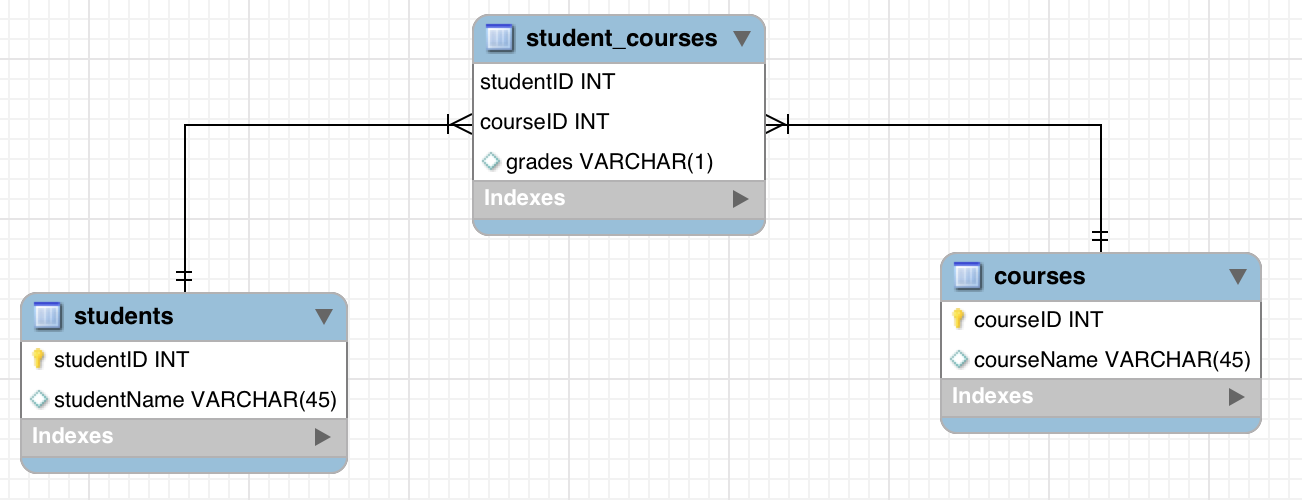

In [22]:
from IPython.display import Image
Image(filename='data/modelDiag_gradingSystem.png') 

In [23]:
conn = MySQLdb.connect(host="localhost", user="root")
cur = conn.cursor()
#cur.execute("Drop DATABASE student_grade_central_system")
cur.execute("CREATE DATABASE student_grade_central_system")
cur.close() 
#conn = MySQLdb.connect(host="localhost", user="root", db="student_grade_central_system")

In [24]:
sqlQuery = '''  
            USE student_grade_central_system;
            
            CREATE TABLE Students (
                StudentID INT NOT NULL, 
                StudentName varchar(45),  
                    PRIMARY KEY(StudentID)
            )   ENGINE=INNODB;
            
            CREATE TABLE Courses (
                CourseID INT NOT NULL, 
                CourseName varchar(45),   
                 PRIMARY KEY(CourseID)
            )   ENGINE=INNODB; 
             
               
            CREATE TABLE student_courses (  
                StudentID INT NOT NULL, 
                CourseID INT NOT NULL, 
                Grade varchar(1),
                     FOREIGN KEY (StudentID)  REFERENCES Students(StudentID),
                     FOREIGN KEY (CourseID)  REFERENCES Courses(CourseID) 
            )   ENGINE=INNODB;
             
            '''

In [25]:
cur = conn.cursor()
cur.execute(sqlQuery)
cur.close() 

In [26]:
sqlQuery = ''' 
        
        USE student_grade_central_system;
            
        INSERT INTO Students (StudentID, StudentName)
        VALUES (100, 'Harry'),
               (101, 'Liam'),
               (102, 'Emma'),
               (103, 'Noah'),
               (104, 'Olivia'),
               (105, 'Ethan'),
               (106, 'Ava'),
               (107, 'Mason'),
               (108, 'Sophia'),
               (109, 'Lucas'),
               (110, 'Isabella'),
               (111, 'Oliver'),
               (112, 'Mia'),
               (113, 'Aiden'),
               (114, 'Charlotte'),
               (115, 'Elijah'),
               (116, 'AmeliaEmma'),
               (117, 'James'),
               (118, 'Harper'),
               (119, 'Benjamin'),
               (120, 'Abigail');
                
        
        INSERT INTO Courses (CourseID, CourseName)
        VALUES (1, 'Histroy'),
               (2, 'Psychology'),     
               (3, 'Science'),
               (4, 'Law'),
               (5, 'English');
        
        INSERT INTO student_courses (StudentID, CourseID, Grade)
        VALUES (100, 1, 'A'),  (100, 2, 'A'), (100, 3, 'A'),  (100, 4, 'A'), (100, 5, 'A'), 
               (101, 1, 'A'),  (101, 2, 'A'), 
               (102, 3, 'D'),  (102, 2, 'C'),  (102, 1, 'B'), 
               (103, 2, 'B'),  (103, 3, 'B'),  (103, 5, 'B'), 
               (104, 1, 'B'), 
               (105, 3, 'B'),
               (106, 2, 'C'),  (106, 1, 'D'),   
               (107, 1, 'A'),  (107, 2, 'C'),  (107,5, 'C'),
               (108, 1, 'C'),  (108, 2, 'B'),
               (109, 1, 'F'),  (109, 1, 'B'),
               (110, 1, 'A'),  (110, 4, 'B'),
               (111, 5, 'D'),
               (112, 2, 'F'),  (112, 4, 'C'),
               (113, 1, 'A'),  (113, 2, 'B'),
               (114, 2, 'B'),  (114, 4, 'A'),
               (115, 2, 'A'),  (115, 4, 'A'),  (115, 5, 'B'),
               (116, 1, 'A'),  (116, 2, 'B'),  (116, 5, 'C'),
               (117, 5, 'E'),
               (118, 2, 'A'),  (118, 4, 'D'),
               (119, 1, 'A'),  (119, 2, 'C'),
               (120, 1, 'F');
               
            ''' 

In [27]:
cur = conn.cursor()
cur.execute(sqlQuery)
cur.close() 
conn.commit()

In [28]:
cursor = conn.cursor()
cursor.execute("SELECT * FROM student_grade_central_system.student_courses limit 10") 
result = cursor.fetchall() 
prettyPrint(result, cursor)
#sample of grade table

+-----------+----------+-------+
| StudentID | CourseID | Grade |
+-----------+----------+-------+
| 100       | 1        | A     |
| 100       | 2        | A     |
| 100       | 3        | A     |
| 100       | 4        | A     |
| 100       | 5        | A     |
| 101       | 1        | A     |
| 101       | 2        | A     |
| 102       | 3        | D     |
| 102       | 2        | C     |
| 102       | 1        | B     |
+-----------+----------+-------+


In [29]:
# we now find top 10 students who have the top 10 grade point average

In [30]:
sqlQuery = '''

        select students.StudentName, AVG(temp.g) as gpa
        from
                (SELECT * , case 
                                when Grade = 'A' then 4
                                when Grade = 'B' then 3
                                when Grade = 'C' then 2
                                when Grade = 'D' then 1
                            Else 0 
                            end as g
                FROM student_courses) as temp
        left join students
        on temp.studentID = students.StudentID
        group by temp.studentID 
        order by gpa desc
        limit 10

'''

In [31]:
cursor = conn.cursor()
cursor.execute(sqlQuery) 
result = cursor.fetchall() 
prettyPrint(result, cursor)

+-------------+--------+
| StudentName | gpa    |
+-------------+--------+
| Harry       | 4.0000 |
| Liam        | 4.0000 |
| Elijah      | 3.6667 |
| Charlotte   | 3.5000 |
| Aiden       | 3.5000 |
| Isabella    | 3.5000 |
| Noah        | 3.0000 |
| Ethan       | 3.0000 |
| Benjamin    | 3.0000 |
| AmeliaEmma  | 3.0000 |
+-------------+--------+


In [32]:
##unlike MSsql, mysql doesnot have top percent with ties so it may be easier to use pandas

import pandas as pd
df = pd.read_sql(sqlQuery.replace("limit 10", ""), con=conn)   
df

,StudentName,gpa
0,Harry,4.0000
1,Liam,4.0000
2,Elijah,3.6667
3,Charlotte,3.5000
4,Aiden,3.5000
5,Isabella,3.5000
6,Noah,3.0000
7,Ethan,3.0000
8,Benjamin,3.0000
9,AmeliaEmma,3.0000


In [33]:
total_std = df.count()[0]

#the 10 percent cutoff
cutoff = df.ix[total_std/10]['gpa']


In [34]:
#this takes care of ties

df[df['gpa']>=cutoff]

,StudentName,gpa
0,Harry,4.0000
1,Liam,4.0000
2,Elijah,3.6667


In [35]:
conn.close()

In [36]:
#! mysql.server status
! mysql.server stop

Shutting down MySQL
.. SUCCESS! 
